Data Collection Time Stats:

- For transcript 5686, 1959 tokens needs to be tagged
- 1701 Unique Tokens received tags with WordNet sense(s).
- 5693 Tags received.

```
Participant   Time Taken	# Tokens Received Tags In WordNet			Speed (tokens/min)
62            11.5 h 		1653										2.3957

60            12.5 h 		1665										2.2200

61            10   h		1648										2.7467
```

AVG Speed (tokens/min/person): 2.454

In Collection 3 (Eng-NA), there are in total 3,748,763 tokens that requires tagging


# Data Preview

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


tags_df = pd.read_csv("tags.csv", names=["gloss_with_replacement",
                                         "participant_id",
                                         "sense_offset",
                                         "part_of_speech",
                                         "token_id"],
                      header=None
                      )

tags_df.sense_offset = tags_df.sense_offset.fillna(0)
tags_df.sense_offset = tags_df.sense_offset.astype(int)

print(tags_df[:10])


  gloss_with_replacement  participant_id  sense_offset part_of_speech  \
0                   like              55       1825962              v   
1                  think              55        628491              v   
2                  think              55        631737              v   
3                  think              55        689344              v   
4                  think              55        689809              v   
5                 reason              55       5819149              n   
6                     do              55       2561995              v   
7                pretend              55       2275799              v   
8                 school              55       4146050              n   
9                 school              55       8276720              n   

   token_id  
0   4013210  
1   5124933  
2   5124933  
3   5124933  
4   5124933  
5   5125176  
6   5125581  
7   4287775  
8   4287803  
9   4287803  


## Basic Stats

In [3]:
grouped_df = tags_df.groupby(["participant_id", "token_id"]).size().groupby(level=0)

for key, item in grouped_df:
    print("participant_id", "\t\t# of tokens tagged")
    print(key, "\t\t\t", grouped_df.get_group(key).size, "\n\n")


participant_id 		# of tokens tagged
55 			 25 


participant_id 		# of tokens tagged
59 			 5 


participant_id 		# of tokens tagged
60 			 1665 


participant_id 		# of tokens tagged
61 			 1648 


participant_id 		# of tokens tagged
62 			 1653 




According to the above data, choosing participant 60, 61, 62 as targets.

# Preparation

In [4]:
participant_ids = [60, 61, 62]

token_id_set = set(tags_df.token_id.unique())
print("# of Tokens: ", len(token_id_set))

from nltk.corpus import wordnet as wn

pos_map = {
    'v': wn.VERB,
    'n': wn.NOUN,
    'adj': wn.ADJ,
    'adv': wn.ADV
}

from collections import defaultdict, Counter

tags_count_smooth = defaultdict(Counter)

# of Tokens:  1701


### Random Data Generation

In [5]:
import random

grouped_token = tags_df.groupby(["token_id", "participant_id"]).size().reset_index(name="size")

raw_tags_df = tags_df.loc[tags_df.participant_id.isin(participant_ids), ["token_id", "participant_id", "sense_offset"]]
random_tags_df = pd.DataFrame()

for token_id in token_id_set:
    token_gloss = tags_df.loc[tags_df.token_id == token_id, "gloss_with_replacement"].iloc[0]
    token_pos = tags_df.loc[tags_df.token_id == token_id, "part_of_speech"].iloc[0]
    senses = list(map(lambda synset_obj: synset_obj.offset(), wn.synsets(token_gloss, pos_map[token_pos])))
    tags_count_smooth[token_id].update(senses)

    for participant_id in participant_ids:
        num_selected_s = grouped_token.loc[
            (grouped_token.token_id==token_id) & (grouped_token.participant_id==participant_id), "size"
        ]
        num_selected = 0 if num_selected_s.empty else num_selected_s.iloc[0]
        
        random.shuffle(senses)
        random_selection = senses[:num_selected]
        for selection in random_selection:
            random_tags_df = random_tags_df.append(
                {"token_id": token_id,
                 "participant_id": participant_id, 
                 "sense_offset": selection}, ignore_index=True).astype(int)

In [6]:
print(len(random_tags_df), len(raw_tags_df))


5691 5693


# Entropy over each token:


### Preprocessing Counts:

In [51]:
from copy import deepcopy

tags_count = defaultdict(Counter)

random_tags_count = defaultdict(Counter)
random_tags_count_smooth = deepcopy(tags_count_smooth)

for token_id in token_id_set:
    chosen_senses = list(raw_tags_df[raw_tags_df.token_id == token_id].sense_offset)
    random_chosen_senses = list(random_tags_df[random_tags_df.token_id == token_id].sense_offset)
    
    tags_count[token_id].update(chosen_senses)
    tags_count_smooth[token_id].update(chosen_senses)
    
    random_tags_count[token_id].update(random_chosen_senses)
    random_tags_count_smooth[token_id].update(random_chosen_senses)
    

from itertools import islice


def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

print(take(10, tags_count.items()))
print(take(10, tags_count_smooth.items()))

print(take(10, random_tags_count.items()))


[(5136384, Counter({1170052: 3})), (5120004, Counter({0: 3})), (5193741, Counter({7745466: 3})), (5103634, Counter({0: 2, 96921: 1})), (5144602, Counter({7828807: 3, 5716462: 1})), (5193754, Counter({7643306: 3})), (5136418, Counter({7914271: 3})), (5160995, Counter({36780: 3, 1251228: 3})), (5095460, Counter({10112591: 3})), (5111857, Counter({3982060: 3}))]
[(5136384, Counter({1170052: 13, 1171183: 1, 1175467: 1, 737005: 1, 1172275: 1})), (5120004, Counter({0: 9, 7392982: 1, 14286549: 1, 7275489: 1, 4693900: 1})), (5193741, Counter({7745466: 10, 12655869: 1, 7123870: 1})), (5103634, Counter({0: 6, 96921: 4, 96333: 1, 97011: 1, 96760: 1, 96636: 1})), (5144602, Counter({7828807: 10, 5716462: 4, 12086539: 1})), (5193754, Counter({7643306: 10, 7643981: 1, 14925198: 1})), (5136418, Counter({7914271: 10, 10615179: 1})), (5160995, Counter({1251228: 10, 36780: 10, 2477755: 1})), (5095460, Counter({10112591: 10, 9785042: 1, 9763784: 1, 10677713: 1, 9679708: 1})), (5111857, Counter({3982060: 1

### Entropy Computation (`scipy.stats.entropy`):

In [56]:

from scipy.stats import entropy


def compute_entropy(tags):
    token_entropy = dict()
    for token_id, tag_count in tags.items():
        token_entropy[token_id] = entropy(list(tag_count.values()))
    return token_entropy


token_entropy = compute_entropy(tags_count)
token_entropy_smooth = compute_entropy(tags_count_smooth)

random_entropy = compute_entropy(random_tags_count)
random_entropy_smooth = compute_entropy(random_tags_count_smooth)

print("Token Entropy: ", take(10, token_entropy.items()), "\n")
print("Token Entropy Smooth: ", take(10, token_entropy_smooth.items()), "\n")

print("Random Entropy: ", take(10, random_entropy.items()), "\n"
      )


Token Entropy:  [(5136384, 0.0), (5120004, 0.0), (5193741, 0.0), (5103634, 0.6365141682948128), (5144602, 0.5623351446188083), (5193754, 0.0), (5136418, 0.0), (5160995, 0.6931471805599453), (5095460, 0.0), (5111857, 0.0)] 

Token Entropy Smooth:  [(5136384, 0.8717814824679821), (5120004, 1.0437938808441543), (5193741, 0.5660857389596289), (5103634, 1.475076311054695), (5144602, 0.8033149761408755), (5193754, 0.5660857389596289), (5136418, 0.30463609734923813), (5160995, 0.8515842539195699), (5095460, 0.994353691762369), (5111857, 1.6111578173439172)] 

Random Entropy:  [(5136384, 0.6365141682948128), (5120004, 0.6365141682948128), (5193741, 0.6365141682948128), (5103634, 1.0986122886681096), (5144602, 1.0397207708399179), (5193754, 0.6365141682948128), (5136418, 0.0), (5160995, 0.6931471805599453), (5095460, 0.6365141682948128), (5111857, 0.6365141682948128)] 



### Plots:

In [57]:
columns=["token_id", "entropy"]

token_entropy_df = pd.DataFrame(token_entropy.items(), columns=columns)
token_entropy_smooth_df = pd.DataFrame(token_entropy_smooth.items(), columns=columns)

random_entropy_df = pd.DataFrame(random_entropy.items(), columns=columns)
random_entropy_smooth_df = pd.DataFrame(random_entropy_smooth.items(), columns=columns)

print(token_entropy_df[:10])
print(random_entropy_smooth_df[:10])


   token_id   entropy
0   5136384  0.000000
1   5120004  0.000000
2   5193741  0.000000
3   5103634  0.636514
4   5144602  0.562335
5   5193754  0.000000
6   5136418  0.000000
7   5160995  0.693147
8   5095460  0.000000
9   5111857  0.000000
   token_id   entropy
0   5136384  1.087761
1   5120004  1.377820
2   5193741  0.721464
3   5103634  1.648847
4   5144602  0.970116
5   5193754  0.959615
6   5136418  0.655482
7   5160995  0.851584
8   5095460  1.215388
9   5111857  1.714743


# of Tokens:  1701


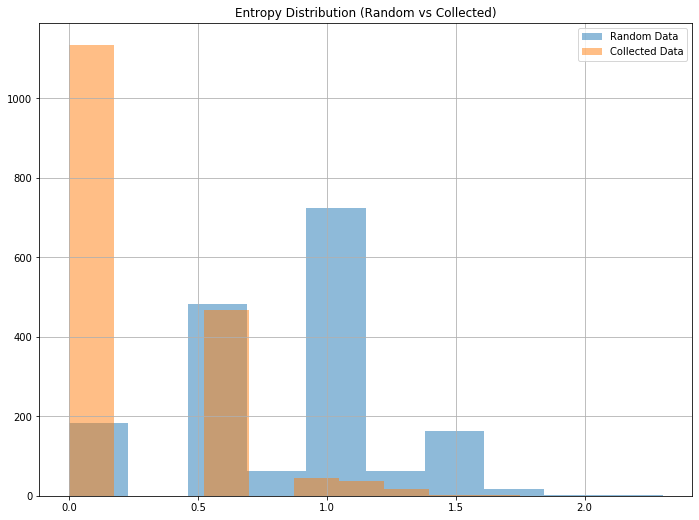

In [62]:
from matplotlib import pyplot

entropy_dist_df = token_entropy_df["entropy"]
random_entropy_dist_df = random_entropy_df["entropy"]
print("# of Tokens: ", len(token_entropy_df))


a4_dims = (11.7, 8.7)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax.set_title("Entropy Distribution (Random vs Collected)")
random_entropy_dist_df.hist(alpha=0.5, label="Random Data", ax=ax)
entropy_dist_df.hist(alpha=0.5, label="Collected Data", ax=ax)
ax.legend()


In [48]:

tokens_df = tags_df[["token_id", "gloss_with_replacement", "part_of_speech"]].drop_duplicates()

merged_token_entropy = pd.merge(token_entropy_df, tokens_df, on="token_id", how="left")

print(merged_token_entropy.sort_values(by="entropy", ascending=False)[:100])

merged_token_entropy.to_csv("tags_entropy.csv", index=False)


      token_id   entropy gloss_with_replacement part_of_speech
1092   5125422  1.747868                 better            adv
668    5139796  1.695743                   make              v
341    5097289  1.549826                   know              v
833    5107832  1.475076                   make              v
940    5108402  1.386294                    see              v
875    5181766  1.386294                   make              v
1441   5176021  1.351784                  world              n
1407   5175893  1.351784                  world              n
949    5133025  1.332179                   come              v
456    5138793  1.332179                  night              n
1170   5101206  1.332179                   have              v
481    5138903  1.329661                  night              n
1041   5141602  1.320888                   make              v
720    5090917  1.313834                    end              n
36     5095652  1.277034                     go        


# KL Divergence



### KL Divergence Computation (`scipy.stats.entropy`):

In [84]:
import itertools


def generate_kl(input_tags_df):
    kl_df = pd.DataFrame()
    
    for token_id in token_id_set:
        token_gloss = tags_df.loc[tags_df.token_id == token_id, "gloss_with_replacement"].iloc[0]
        token_pos = tags_df.loc[tags_df.token_id == token_id, "part_of_speech"].iloc[0]
        senses = list(map(lambda synset_obj: synset_obj.offset(), wn.synsets(token_gloss, pos_map[token_pos])))
        
        def get_prob_distribution(tagger):
            chosen_senses_from_tagger = set(input_tags_df.loc[
                (input_tags_df.token_id == token_id) & (input_tags_df.participant_id == tagger), "sense_offset"
            ])
            if not chosen_senses_from_tagger:
                chosen_senses_from_tagger = set(senses)
    
            total_tags_by_tagger = len(chosen_senses_from_tagger)
            return [(2 if sense_i in chosen_senses_from_tagger else 1) / (total_tags_by_tagger + 1) for sense_i in senses ]
        
        kl_sum = 0.0
        for tagger_a, tagger_b in itertools.combinations(participant_ids, 2):
            sense_prob_dist_from_a = get_prob_distribution(tagger_a)
            sense_prob_dist_from_b = get_prob_distribution(tagger_b)
            
            kl_sum += entropy(pk=sense_prob_dist_from_a, qk=sense_prob_dist_from_b)
            
        kl_df = kl_df.append({
            "token_id": token_id,
            "avg_kl": len(participant_ids) * (len(participant_ids) - 1) * kl_sum
        }, ignore_index=True)
    
    kl_df.token_id = kl_df.token_id.astype(int)
    return kl_df


tags_kl_df = generate_kl(raw_tags_df)
random_tags_kl_df = generate_kl(random_tags_df)


### Result Showcase:

In [89]:
print(tags_kl_df[:10])
print(random_tags_kl_df[:10])

merged_token_kl = pd.merge(tags_kl_df, tokens_df, on="token_id", how="left")

print(merged_token_kl.sort_values(by="avg_kl", ascending=False)[:100])

merged_token_kl.to_csv("tags_avg_kl.csv", index=False)


     avg_kl  token_id
0  0.000000   5136384
1  0.000000   5120004
2  0.000000   5193741
3  0.584730   5103634
4  0.649384   5144602
5  0.000000   5193754
6  0.000000   5136418
7  0.000000   5160995
8  0.000000   5095460
9  0.000000   5111857
     avg_kl  token_id
0  1.386294   5136384
1  1.663553   5120004
2  2.079442   5193741
3  2.079442   5103634
4  2.312937   5144602
5  2.079442   5193754
6  0.000000   5136418
7  0.000000   5160995
8  1.386294   5095460
9  0.831777   5111857
        avg_kl  token_id gloss_with_replacement part_of_speech
1471  2.703274   5094221                  there            adv
918   2.187859   5108303                   here            adv
50    2.109654   5120285                   here            adv
62    2.109654   5120346                   here            adv
81    2.109654   5120425                   here            adv
1670  2.109654   5136220               fountain              n
1617  2.092993   5176857                  whole              n
487   2.0794

### Plot:

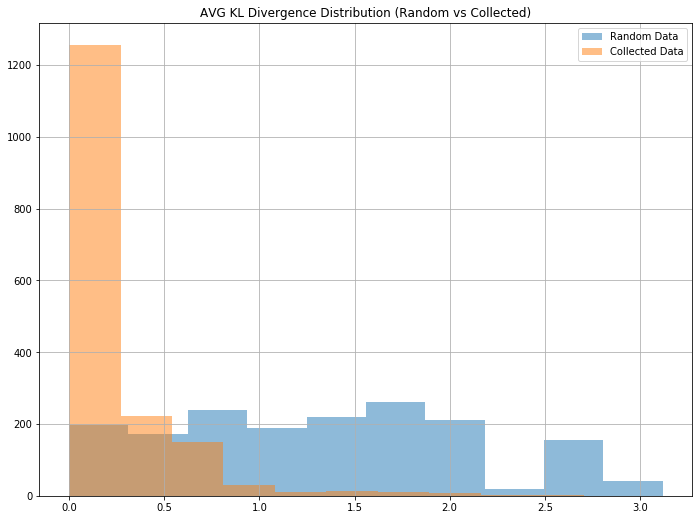

In [87]:
kl_dist_df = tags_kl_df["avg_kl"]
random_kl_dist_df = random_tags_kl_df["avg_kl"]

fig1, ax1 = pyplot.subplots(figsize=a4_dims)
ax1.set_title("AVG KL Divergence Distribution (Random vs Collected)")
random_kl_dist_df.hist(alpha=0.5, label="Random Data", ax=ax1)
kl_dist_df.hist(alpha=0.5, label="Collected Data", ax=ax1)
ax1.legend()
